In [1]:
# Import necessary libraries
import numpy as np, pandas as pd
import random
import time
import os
import matplotlib.pyplot as plt

# Adjust the options for viewing charts in notebook
plt.rcParams.update({'figure.figsize':(12,6), 'figure.dpi':100})

# Adjust options for viewing dataframes in notebook
pd.set_option('display.width', 2000)

In [2]:
# Function for reading a data file
def read_data(name):
    df = pd.read_csv('./../../data/clean_data/' + name + '.csv')
    df['Hour'] = pd.to_datetime(df['Hour'])
    df = df.set_index('Hour')
    df.index.freq = 'h'
    return df

In [3]:
# Function for locating random batches from dataset

## Take dataset, length of test data and number of batches to extract as parameters
## Find a number of digits that represent the indices of the original dataset, where the extracted batches will start from
## Each subset dataset will not intersect with other datasets

def extract_batches(df, test_length, batch_count):
    start = time.time()
    random_int_list = []
    m = 0
    random.seed(1)
    data_end = len(df)
    while m < batch_count:
        random_int = random.randint(0, data_end - test_length)
        q = 0
        for i in random_int_list:
            # Make sure batches do not overlap
            if i + test_length <= random_int or random_int + test_length <= i:
                pass
            else:
                q = 1
                # In case solution does not exist with current combination
                if time.time() - start > 2:
                    print('Restarted')
                    random_int_list = []
                    start = time.time()
                    m = 0

        # Prevent batches with 0 energy
        if df['Energy'][random_int: random_int + test_length].sum() == 0:
            q = 1

        # Record the position of the batch
        if q == 0:
            random_int_list.append(random_int)
            m = m + 1
    return random_int_list

In [4]:
# Range Pricing Method:
# The energy rate assigned to an hour's demand value is dependent on which demand threshold it falls under
# Demand thresholds are calculated by splitting the demand range evenly
# The higher the demand threshold the higher the price assigned

# Function for creating a price profile using the range pricing method

def range_pricing(test, min_price, max_price):

    # Possible prices per kWh are in range [min_price, max_price]
    price_set = [x / 100 for x in range(min_price, max_price + 1)]
    price_set_count = len(price_set)

    # The range of demand is split into equal bins, one for each possible price
    max_demand = max(test)
    min_demand = min(test)
    bin_size = (max_demand - min_demand) / price_set_count

    # Demand thresholds for each price are calculated
    demand_thresholds = []
    j = 1
    while j < price_set_count + 1:
        demand_thresholds.append(min_demand + bin_size * j)
        j = j + 1

    # To tackle float representation imprecision, the highest demand threshold is increased a little
    demand_thresholds[-1] = demand_thresholds[-1] + 1

    # Every demand value is compared with the demand thresholds and assigned a demand-proportional price
    price_profile = []
    i = 0
    while i < len(test):
        j = 0
        while j < price_set_count:
            if test[i] <= demand_thresholds[j]:
                price_profile.append(price_set[j])
                break
            j = j + 1
        i = i + 1

    return price_profile

In [5]:
# Percentile Pricing Method:
# The energy rate assigned to an hour's demand value is dependent on which demand threshold it falls under
# Demand thresholds are calculated by identifying demand values at specific percentile positions
# The higher the demand threshold the higher the price assigned

# Function for creating a price profile using the percentile pricing method

def percentile_pricing(test, min_price, max_price):

    # A list of possible prices in range [min_price, max_price] is created
    price_set = [x / 100 for x in range(min_price, max_price + 1)]
    price_set_count = len(price_set)

    # Percentile thresholds for each price are calculated
    bin_size = 100 / price_set_count
    percentile_thresholds = []
    j = 1
    while j < price_set_count + 1:
        percentile_thresholds.append(bin_size * j)
        j = j + 1

    # Demand thresholds for each price are calculated
    demand_thresholds = []
    for k in percentile_thresholds:
        demand_thresholds.append(np.percentile(test, k))

    # Every demand value is compared with the demand thresholds and assigned a demand-proportional price
    price_profile = []
    i = 0
    while i < len(test):
        j = 0
        while j < price_set_count:
            if test[i] <= demand_thresholds[j]:
                price_profile.append(price_set[j])
                break
            j = j + 1
        i = i + 1

    return price_profile

In [6]:
# Function for creating a price profile using the flat energy pricing method

def flat_energy_pricing(test, flat_price):
    total_hours = len(test)
    price_profile = []

    i = 0
    while i < total_hours:
        price_profile.append(flat_price)
        i = i + 1
    
    return price_profile

In [7]:
# Function for creating a price profile using the time of use energy pricing method

def tou_pricing(test, tou_dict):
    price_profile = []
    
    for Hour in test.index:
        [min_time, max_time] = tou_dict['time_range']
        [min_period_price, max_period_price] = tou_dict['prices']

        if (Hour.hour < max_time) & (Hour.hour >= min_time):
            price_profile.append(max_period_price)
        else:
            price_profile.append(min_period_price)
    
    return price_profile

In [8]:
# Function for creating price profiles for each pricing method based on demand

def analyse(df, test_length, batch_count):
    # Find appropriate (random) start indices for batches to prevent overlap
    start_index_list = extract_batches(df, test_length, batch_count)
    
    # Create a list to store every batch's demand and price profiles
    all_batch_price_profiles = []

    for start_index in start_index_list:
        # Retrieve the batch test data
        test = df[start_index: start_index + test_length]

        # Calculate hourly demand profile in batch
        demand_value_profile = test['Energy']

        # Calculate the price profile for each pricing method: 
        ## Flat Energy Pricing Method (0.23 dollars per kWh)
        flat_energy_price_profile = flat_energy_pricing(test['Energy'], 0.23)

        ## Time of Use Pricing Method (0.25 dollars per kWh between 08:00 - 21:00, 0.2 dollars otherwise )
        tou_dict = {'time_range': [8, 21], 'prices': [0.20, 0.25]}
        tou_price_profile = tou_pricing(test['Energy'], tou_dict)

        ## Range Pricing Method
        range_price_profile = range_pricing(test['Energy'], 20, 25)

        ## Percentile Pricing Method
        percentile_price_profile = percentile_pricing(test['Energy'], 20, 25)

        # Create dictionary containing demand profile and every price profile of current batch
        price_profiles_dict = {
                'Energy (kWh)': demand_value_profile,
                'Flat Energy': flat_energy_price_profile,
                'Time of Use': tou_price_profile,
                'Range Method': range_price_profile,
                'Percentile Method': percentile_price_profile}

        # Create batch_price_profile dataframe containing demand profile and every price profile of current batch
        batch_price_profile = pd.DataFrame(price_profiles_dict)

        # Store batch_price_profile dataframe
        all_batch_price_profiles.append(batch_price_profile)

    return all_batch_price_profiles

In [9]:
# Function for visualising the proportionality between demand and price profile of each pricing method

def price_profile_plot(price_profile, save):
    x = price_profile.index

    # Create four subplots
    fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1)

    # Set the ticks and labels for figure
    fig.suptitle('Line Plot Comparing Pricing Methods on Demand-Proportionality')
    fig.supylabel('Price per kWh ($)')
    fig.supxlabel('Time')

    # Update the label size and add grid
    for ax in [ax1, ax2, ax3, ax4]:
        ax.tick_params(axis='y', labelsize=8)
        ax.yaxis.grid(True, color='lightgrey', linestyle='--', linewidth=0.5)

    # Create a second set of axes for demand
    ax12 = ax1.twinx()
    ax22 = ax2.twinx()
    ax32 = ax3.twinx()
    ax42 = ax4.twinx()

    # Plot each pricing method's line plot
    ax1.plot(x, price_profile['Flat Energy'], '-', color="limegreen", label='Flat Energy', linewidth="2")
    ax2.plot(x, price_profile['Time of Use'], '-', color="orange", label='Time of Use', linewidth="2") 
    ax3.plot(x, price_profile['Range Method'], '-', color="dodgerblue", label='Range Method', linewidth="2")
    ax4.plot(x, price_profile['Percentile Method'], '-', color="violet", label='Percentile Method',  linewidth="2")

    # In each subplot, plot demand
    ax12.plot(x, price_profile['Energy (kWh)'], '-', color="black", label='Energy')
    ax22.plot(x, price_profile['Energy (kWh)'], '-', color="black")
    ax32.plot(x, price_profile['Energy (kWh)'], '-', color="black")
    ax42.plot(x, price_profile['Energy (kWh)'], '-', color="black")

    # Add labels for the axes on the right
    for ax in [ax12, ax22, ax32, ax42]:
        ax.set_ylabel('Energy (kWh)')

    # Set titles for each subplot
    ax1.set_title('Flat Energy', fontsize=11, loc='left')
    ax2.set_title('Time of Use', fontsize=11, loc='left')
    ax3.set_title('Range Method', fontsize=11, loc='left')
    ax4.set_title('Percentile Method', fontsize=11, loc='left')

    # Correct yticks
    plt.setp(((ax1, ax2, ax3, ax4)), yticks=[0.20, 0.21, 0.22, 0.23, 0.24, 0.25])

    # Fix plot layout
    fig.tight_layout(h_pad=2)

    # Add legend
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    if save == "Yes":
        target_dir = '../../visualisations/demand_proportionality'
        if not os.path.isdir(target_dir):
            os.makedirs(target_dir)

        # Save the plot
        plot_path1 = '../../visualisations/demand_proportionality/line_plot_demand_proportionality.png'
        plt.savefig(plot_path1, bbox_inches='tight', pad_inches=0.3)


In [10]:
# Function for visualising the proportionality between demand and hourly price of each pricing method
def price_profile_scatter(price_profile, save):
    x = price_profile['Energy (kWh)']

    # Create four subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    # Set the ticks and labels for figure
    fig.suptitle('Scatter Plot of Hour Price vs. Demand by Pricing Method')
    fig.supylabel('Price per kWh ($)')
    fig.supxlabel('Energy (kWh)')

    # Plot each pricing method's scatterplot
    ax1.scatter(x, price_profile['Flat Energy'], s=50, color="limegreen", label='Flat Energy')
    ax2.scatter(x, price_profile['Time of Use'], s=50, color="orange", label='Time of Use')
    ax3.scatter(x, price_profile['Range Method'], s=50, color="dodgerblue", label='Range Method')
    ax4.scatter(x, price_profile['Percentile Method'], s=50, color="violet", label='Percentile Method')

    # Set titles for each subplot
    ax1.set_title('Flat Energy')
    ax2.set_title('Time of Use')
    ax3.set_title('Range Method')
    ax4.set_title('Percentile Method')

    # Correct yticks
    plt.setp(((ax1, ax2), (ax3, ax4)), yticks=[0.20, 0.21, 0.22, 0.23, 0.24, 0.25])

    # Fix plot layout
    fig.tight_layout()

    # Add legend
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Add grid
    for ax in [ax1, ax2, ax3, ax4]:
        ax.yaxis.grid(True, color='lightgrey', linestyle='--', linewidth=0.5)
    
    if save == "Yes":
        target_dir = '../../visualisations/demand_proportionality'
        if not os.path.isdir(target_dir):
            os.makedirs(target_dir)

        # Save the plot
        plot_path2 = '../../visualisations/demand_proportionality/scatter_plot_demand_proportionality.png'
        plt.savefig(plot_path2, bbox_inches='tight', pad_inches=0.3)



C:\Users\zhangx28\AppData\Local\Temp\ipykernel_10180\1885999543.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if test[i] <= demand_thresholds[j]:
C:\Users\zhangx28\AppData\Local\Temp\ipykernel_10180\4193881609.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if test[i] <= demand_thresholds[j]:


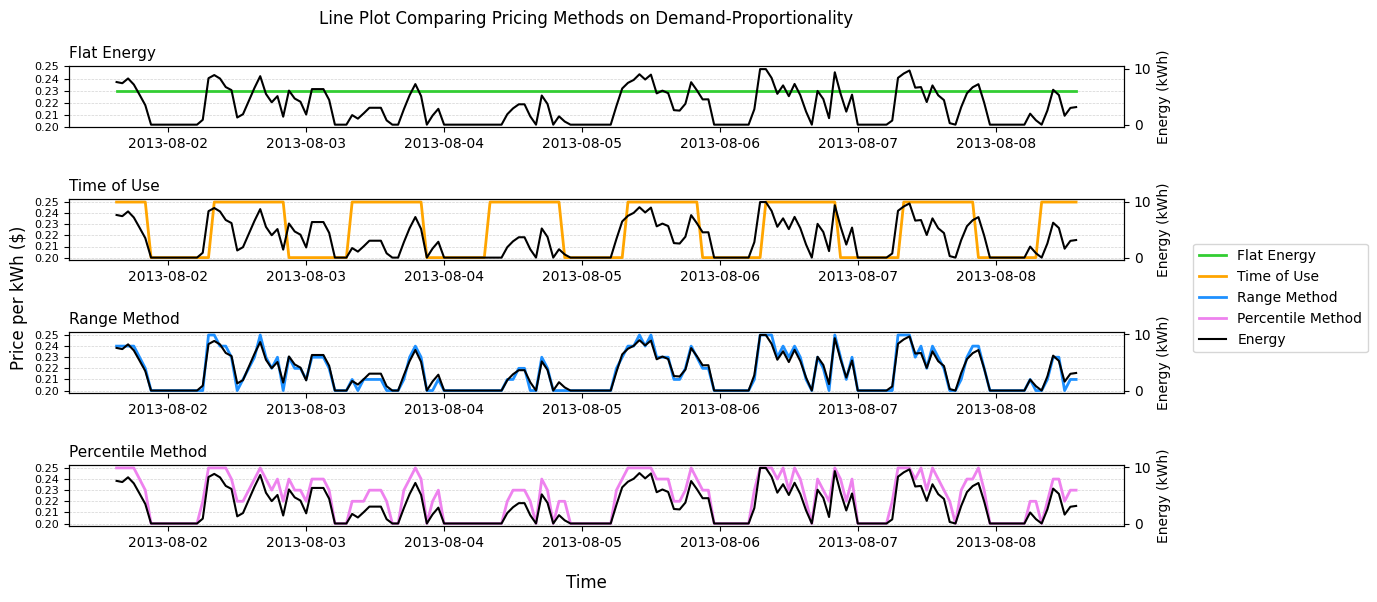

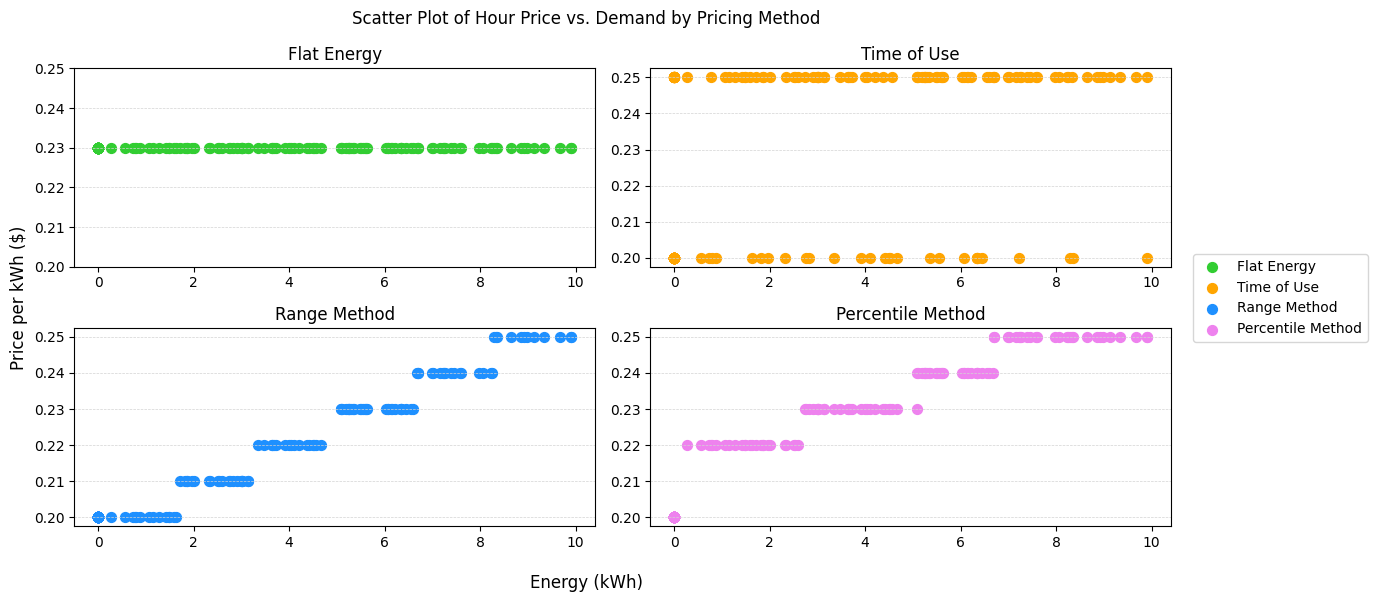

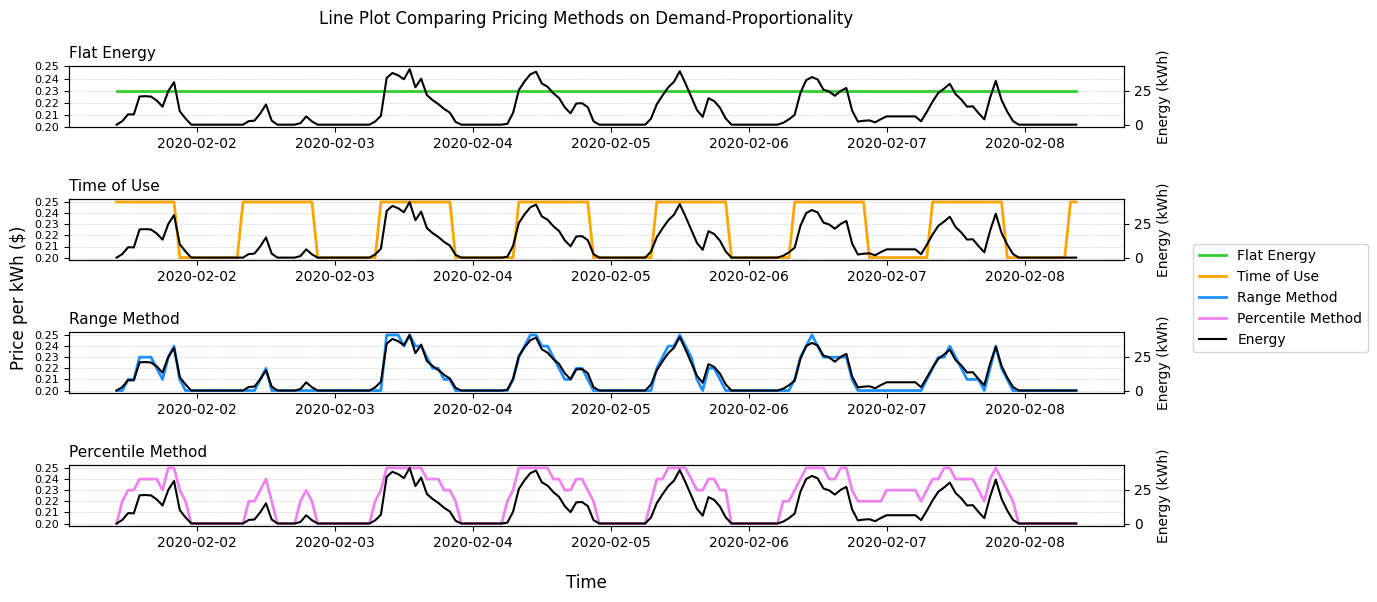

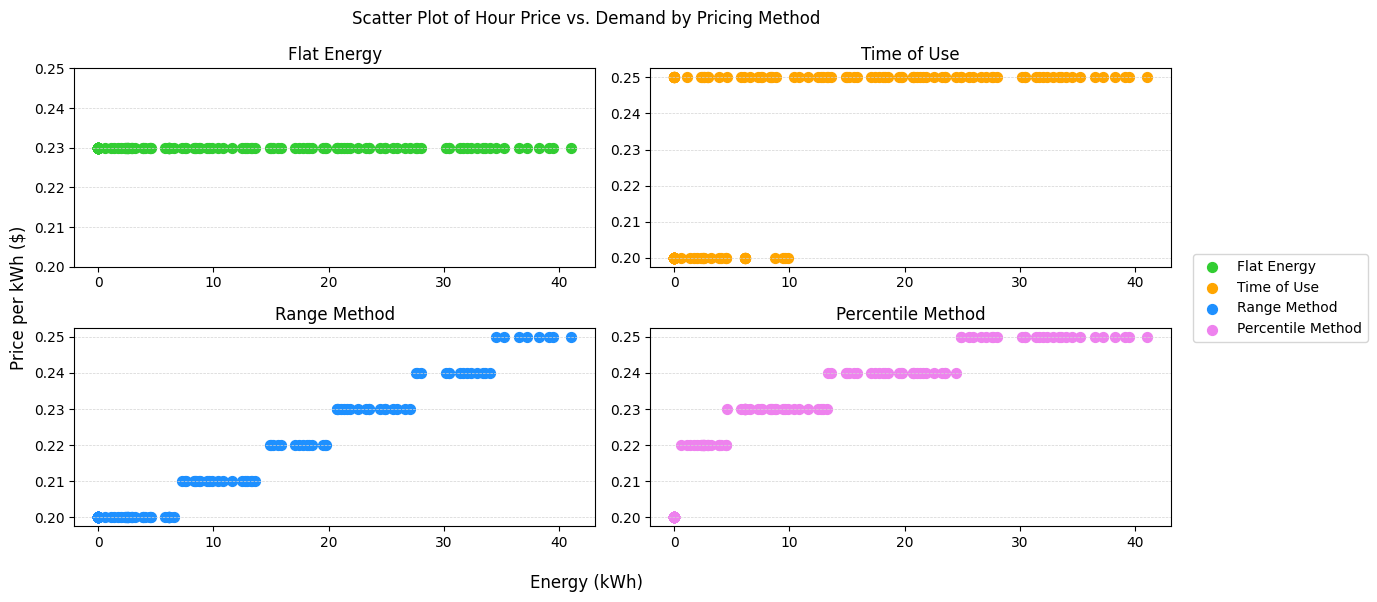

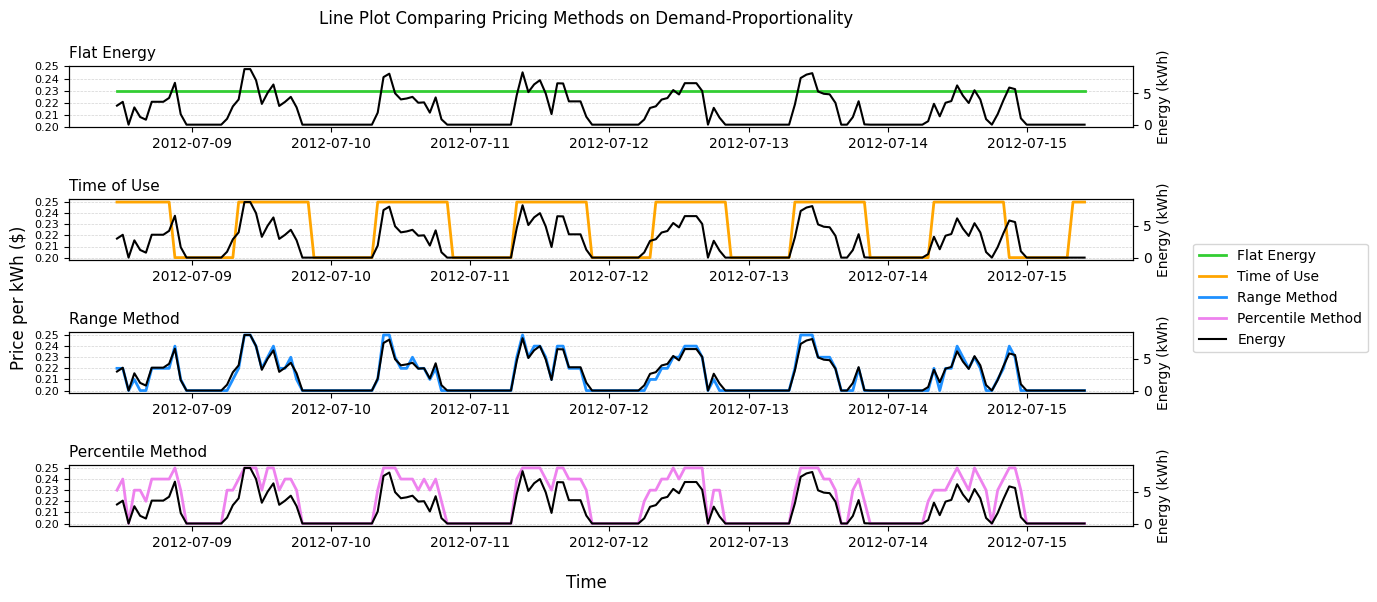

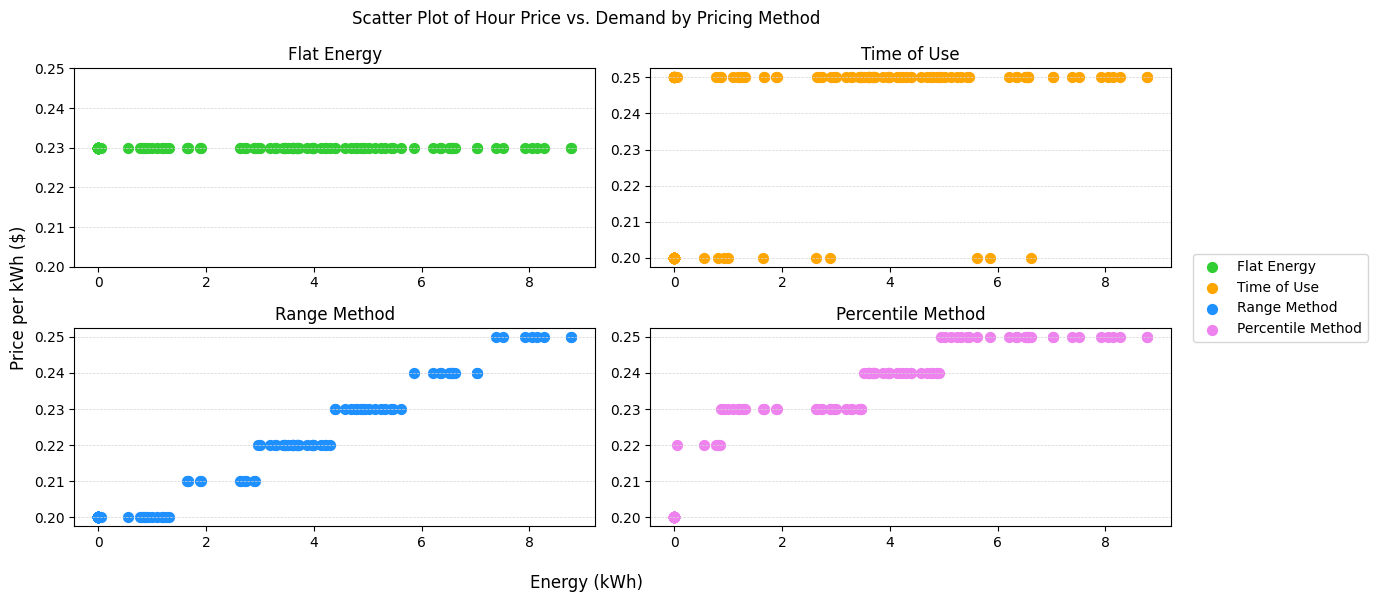

In [11]:
# Function for creating price profiles for BRYANT station (2 batches, each with 7 days period) and visualising the results

def main():
    df = read_data('BRYANT')
    price_profiles = analyse(df, 168, 3)

    for price_profile in price_profiles:
        price_profile_plot(price_profile, "Yes")
        price_profile_scatter(price_profile, "Yes")

main()